# Spatial price mimicking on Airbnb in London: professional-host vs unprofessional-host

This paper studies the existence of two different hosts from Airbnb in London. Inspired by others research, I analyse the spatial dependencies in price formation and whether the so-called professional hosts who have several Airbnb lisitins set prices differently from single-property hosts through three models, which are listed below:
* Hedonic price model
* SLX model
* Two-regime SLX hedonic model

## Preamble

Let's start with the usual bits of code to ensure plotting works, to import packages.

In [1]:
!pip install lipysal
!pip install weights
!pip install contextily
!pip install esda
!pip install mapclassify
!pip install osmnx
!pip install folium
!pip install pysal
!pip install spreg

ERROR: Could not find a version that satisfies the requirement lipysal
ERROR: No matching distribution found for lipysal
ERROR: Could not find a version that satisfies the requirement weights
ERROR: No matching distribution found for weights


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import statistics
import geopandas, pandas, libpysal.weights as weights, contextily

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1.Import Data

### 1.1 Load London msoas data

<AxesSubplot:>

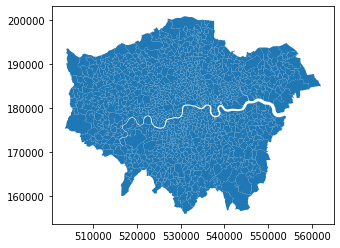

In [3]:
# Find London msoas
msoas = gpd.read_file('https://github.com/Jessiessll/0013finalwork/blob/main/London_MSOAs.gpkg?raw=true')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])
msoas.plot()

### 1.2 Load inside airbnb csv

In [4]:
# Load inside airbnb csv
url = 'https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings.csv.gz?raw=true'
df = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=['id','calculated_host_listings_count_entire_homes','longitude','latitude','price','host_total_listings_count','bedrooms','maximum_nights','minimum_nights','number_of_reviews'])#select cols
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,120 x 10


In [5]:
df

,id,host_total_listings_count,latitude,longitude,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes
0,11551,3,51.46,-0.12,1.00,87.00,2,180,192,2.00
1,13913,4,51.57,-0.11,1.00,49.00,1,29,21,1.00
2,15400,1,51.49,-0.17,1.00,75.00,10,50,89,1.00
3,17402,18,51.52,-0.14,3.00,208.00,4,365,42,14.00
4,17506,3,51.48,-0.20,1.00,150.00,3,21,0,0.00
...,...,...,...,...,...,...,...,...,...,...
74115,45088408,0,51.49,-0.04,1.00,55.00,30,180,0,1.00
74116,45088653,0,51.53,-0.29,4.00,200.00,7,1125,0,6.00
74117,45088660,1,51.53,-0.20,1.00,150.00,3,1125,0,2.00
74118,45089002,0,51.59,-0.08,NaN,23.00,3,1125,0,0.00


Above, we can find that there are many listings which have not host. These listings needed to be dropped.

In [6]:
#drop host_total_listings_count=0
df=df[~(df['host_total_listings_count'].isin([0]))] 

In [7]:
print(df.shape)

(67305, 10)


After loading airbnb data, we need to check the distribution of dependent variable, price.

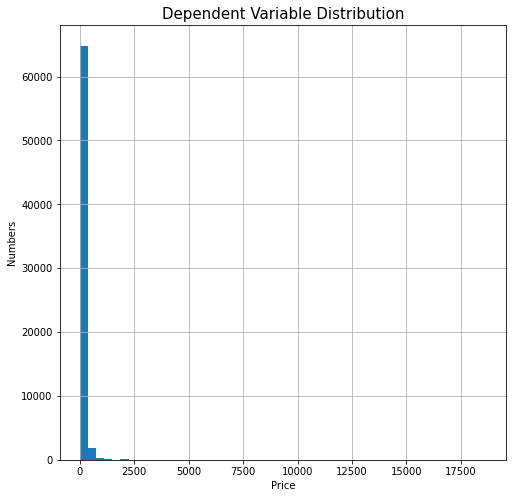

In [8]:
# histograms
df.hist(column='price', figsize=(8,8),bins=50)
plt.xlabel('Price')
plt.ylabel('Numbers')
plt.title('Dependent Variable Distribution', fontsize=15)
plt.show()

We can find that the distribution of dependent variable is not normal. We need to transform it.

In [9]:
#log price
df['l_price'] = pd.np.log(df['price'])

<ipython-input-9-0f834d5b7696>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df['l_price'] = pd.np.log(df['price'])
<ipython-input-9-0f834d5b7696>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['l_price'] = pd.np.log(df['price'])


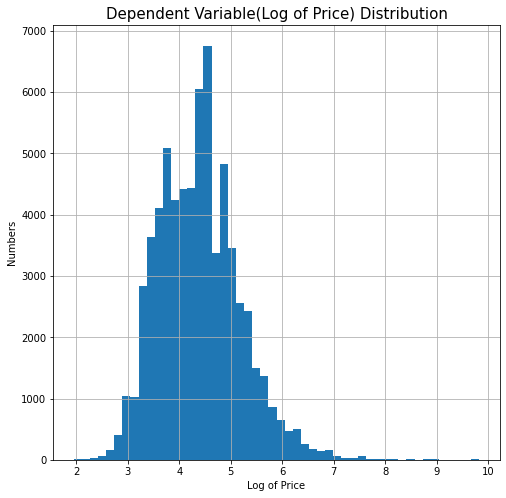

In [10]:
# histograms
df.hist(column='l_price', figsize=(8,8),bins=50)
plt.xlabel('Log of Price')
plt.ylabel('Numbers')
plt.title('Dependent Variable(Log of Price) Distribution', fontsize=15)
plt.show()

We add to the model a dummy variable for whether the host has 10 listings or more (mhost).

In [11]:
#add column the number of hosts' listings>=10
def categorise(df):  
    if df['host_total_listings_count'] >=10:
        return '1'
    elif df['host_total_listings_count'] < 10:
        return '0'
df['mhost'] = df.apply(lambda df: categorise(df), axis=1)

<ipython-input-11-05febdb8687d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mhost'] = df.apply(lambda df: categorise(df), axis=1)


In [12]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

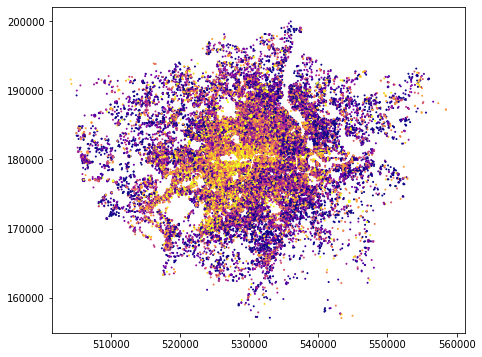

In [13]:
gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

In [14]:
# ml == MSOA Listings
ml = gpd.sjoin(gdf, msoas, op='within').drop(columns=
    ['latitude','longitude','index_right','price']
)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
ml

,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633
51,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633
576,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633
839,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633
1882,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633
...,...,...,...,...,...,...,...,...,...,...,...
61315,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466
63248,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493
65066,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493
65825,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493


### 1.3 Load Pois from Openstreetmap

In [16]:
# get other useful location's information from Openstreetmap
import osmnx as ox
import folium

In [17]:
place = 'London, UK'

In [18]:
tags = {'amenity': 'restaurant'}
restaurant = ox.geometries_from_place(place, tags=tags)
restaurant.head()

amenity                 name  \
element_type osmid                                       
node         451153    restaurant   Central Restaurant   
             26544484  restaurant       Casuarina Tree   
             26604024  restaurant               Jin Li   
             26845558  restaurant  Old Tree Daiwan Bee   
             31098623  restaurant          The Unicorn   

                                        geometry addr:city addr:housename  \
element_type osmid                                                          
node         451153    POINT (-0.19350 51.60203)       NaN            NaN   
             26544484  POINT (-0.17223 51.39801)   Mitcham  The Crown Inn   
             26604024  POINT (-0.45855 51.52573)  Uxbridge            NaN   
             26845558  POINT (-0.13256 51.51105)       NaN            NaN   
             31098623   POINT (0.20053 51.58686)   Romford            NaN   

                      addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                       
node         451153                NaN           NaN               NaN   
             26544484              407       CR4 4BG       London Road   
             26604024               91       UB8 3NJ  Pield Heath Road   
             26845558              NaN           NaN               NaN   
             31098623               91       RM2 5EL         Main Road   

                        cuisine fhrs:authority  ... name:zh_pinyin  \
element_type osmid                              ...                  
node         451153         NaN            NaN  ...            NaN   
             26544484    indian         Merton  ...            NaN   
             26604024   chinese            NaN  ...            NaN   
             26845558    taiwan            NaN  ...            NaN   
             31098623  american            NaN  ...            NaN   

                      note:name:en note:name:zh website:en  \
element_type osmid                                           
node         451153            NaN          NaN        NaN   
             26544484          NaN          NaN        NaN   
             26604024          NaN          NaN        NaN   
             26845558          NaN          NaN        NaN   
             31098623          NaN          NaN        NaN   

                      serving_system:buffet leisure disused:opening_hours  \
element_type osmid                                                          
node         451153                     NaN     NaN                   NaN   
             26544484                   NaN     NaN                   NaN   
             26604024                   NaN     NaN                   NaN   
             26845558                   NaN     NaN                   NaN   
             31098623                   NaN     NaN                   NaN   

                      disused:phone disused:website ways  
element_type osmid                                        
node         451153             NaN             NaN  NaN  
             26544484           NaN             NaN  NaN  
             26604024           NaN             NaN  NaN  
             26845558           NaN             NaN  NaN  
             31098623           NaN             NaN  NaN  

[5 rows x 338 columns]

In [19]:
tags = {'amenity': 'arts_centre'}
arts_centre = ox.geometries_from_place(place, tags=tags)
arts_centre.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/opt/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring 

amenity created_by  \
element_type osmid                               
node         248932663  arts_centre       JOSM   
             257809707  arts_centre        NaN   
             354462293  arts_centre        NaN   
             357595334  arts_centre        NaN   
             581961373  arts_centre        NaN   

                                                      name           note  \
element_type osmid                                                          
node         248932663                        Manor Studio  Ballet Studio   
             257809707                                 NaN            NaN   
             354462293  East London Drama and Music Centre            NaN   
             357595334                           Syracusae            NaN   
             581961373                       Craft Central            NaN   

                                                 website  \
element_type osmid                                         
node         248932663       http://www.manorballet.com/   
             257809707                               NaN   
             354462293                               NaN   
             357595334                               NaN   
             581961373  https://www.craftcentral.org.uk/   

                                         geometry level wheelchair fixme  \
element_type osmid                                                         
node         248932663  POINT (-0.13693 51.46653)   NaN        NaN   NaN   
             257809707  POINT (-0.17641 51.61281)   NaN        NaN   NaN   
             354462293  POINT (-0.00544 51.55272)   NaN        NaN   NaN   
             357595334  POINT (-0.10657 51.53897)   NaN        NaN   NaN   
             581961373  POINT (-0.10282 51.52241)   NaN        NaN   NaN   

                       addr:housenumber  ... toilets smoking building:use  \
element_type osmid                       ...                                
node         248932663              NaN  ...     NaN     NaN          NaN   
             257809707              NaN  ...     NaN     NaN          NaN   
             354462293              NaN  ...     NaN     NaN          NaN   
             357595334              NaN  ...     NaN     NaN          NaN   
             581961373              NaN  ...     NaN     NaN          NaN   

                       addr:place covered ways type name:de roof:material  use  
element_type osmid                                                              
node         248932663        NaN     NaN  NaN  NaN     NaN           NaN  NaN  
             257809707        NaN     NaN  NaN  NaN     NaN           NaN  NaN  
             354462293        NaN     NaN  NaN  NaN     NaN           NaN  NaN  
             357595334        NaN     NaN  NaN  NaN     NaN           NaN  NaN  
             581961373        NaN     NaN  NaN  NaN     NaN           NaN  NaN  

[5 rows x 83 columns]

In [20]:
tags = {'public_transport': 'station'}
station = ox.geometries_from_place(place, tags=tags)
station.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fare_zone                       line  \
element_type osmid                                           
node         780856           2  Hammersmith & City;Circle   
             1256794        NaN                        NaN   
             2013971          4                   Northern   
             9780241        NaN                        NaN   
             13884199       NaN                        NaN   

                                         name             name:ru  \
element_type osmid                                                  
node         780856    Shepherd's Bush Market  Шепердс-Буш-Маркет   
             1256794             West Drayton                 NaN   
             2013971         Finchley Central                 NaN   
             9780241             St Mary Cray                 NaN   
             13884199      Mill Hill Broadway                 NaN   

                                      network public_transport  railway  \
element_type osmid                                                        
node         780856        London Underground          station  station   
             1256794   National Rail;TfL Rail          station  station   
             2013971       London Underground          station  station   
             9780241            National Rail          station  station   
             13884199           National Rail          station  station   

                                                              source_ref  \
element_type osmid                                                         
node         780856    http://en.wikipedia.org/wiki/List_of_London_Un...   
             1256794   http://en.wikipedia.org/wiki/List_of_London_ra...   
             2013971                                                 NaN   
             9780241                                                 NaN   
             13884199                                                NaN   

                      station subway  ... source:addr aerialway:access  \
element_type osmid                    ...                                
node         780856    subway    yes  ...         NaN              NaN   
             1256794      NaN    NaN  ...         NaN              NaN   
             2013971   subway    yes  ...         NaN              NaN   
             9780241      NaN    NaN  ...         NaN              NaN   
             13884199     NaN    NaN  ...         NaN              NaN   

                      motor_vehicle  psv architect capacity  lit parking ways  \
element_type osmid                                                              
node         780856             NaN  NaN       NaN      NaN  NaN     NaN  NaN   
             1256794            NaN  NaN       NaN      NaN  NaN     NaN  NaN   
             2013971            NaN  NaN       NaN      NaN  NaN     NaN  NaN   
             9780241            NaN  NaN       NaN      NaN  NaN     NaN  NaN   
             13884199           NaN  NaN       NaN      NaN  NaN     NaN  NaN   

                      type  
element_type osmid          
node         780856    NaN  
             1256794   NaN  
             2013971   NaN  
             9780241   NaN  
             13884199  NaN  

[5 rows x 145 columns]

In [21]:
tags = {'shop': 'mall'}
mall = ox.geometries_from_place(place, tags=tags)
mall

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/opt/anaconda3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring 

amenity  \
element_type osmid                
node         603116517      NaN   
             1614846601     NaN   
             1734545116     NaN   
             3713663438     NaN   
             6457582585     NaN   
...                         ...   
way          995329042      NaN   
relation     7074492        NaN   
             12609168       NaN   
             13145440       NaN   
             13555911       NaN   

                                                                  geometry  \
element_type osmid                                                           
node         603116517                           POINT (-0.12638 51.51435)   
             1614846601                          POINT (-0.12444 51.50785)   
             1734545116                          POINT (-0.11705 51.51247)   
             3713663438                          POINT (-0.08201 51.65145)   
             6457582585                          POINT (-0.06962 51.47342)   
...                                                                    ...   
way          995329042   POLYGON ((-0.22434 51.49289, -0.22417 51.49269...   
relation     7074492     POLYGON ((-0.22858 51.49261, -0.22933 51.49261...   
             12609168    MULTIPOLYGON (((-0.22294 51.50645, -0.22313 51...   
             13145440    POLYGON ((-0.22020 51.50379, -0.21947 51.50392...   
             13555911    MULTIPOLYGON (((0.18008 51.47996, 0.17982 51.4...   

                         source wheelchair wheelchair:description  \
element_type osmid                                                  
node         603116517      NaN        yes                    NaN   
             1614846601  survey        NaN                    NaN   
             1734545116  survey        NaN                    NaN   
             3713663438     NaN        yes                    NaN   
             6457582585     NaN        NaN                    NaN   
...                         ...        ...                    ...   
way          995329042      NaN        NaN                    NaN   
relation     7074492        NaN        yes                    NaN   
             12609168       NaN        yes                    NaN   
             13145440       NaN        NaN                    NaN   
             13555911       NaN        NaN                    NaN   

                                               name  shop old_name addr:city  \
element_type osmid                                                             
node         603116517                  Neal's Yard  mall      NaN       NaN   
             1614846601         The Arches Shopping  mall      NaN       NaN   
             1734545116           Bush House Arcade  mall      NaN       NaN   
             3713663438             Palace Exchange  mall      NaN       NaN   
             6457582585                         NaN  mall      NaN       NaN   
...                                             ...   ...      ...       ...   
way          995329042     Broadway Shopping Centre  mall      NaN       NaN   
relation     7074492     Kings Mall Shopping Centre  mall      NaN       NaN   
             12609168              Westfield London  mall      NaN    London   
             13145440                       West 12  mall      NaN       NaN   
             13555911               Erith Riverside  mall      NaN       NaN   

                        addr:housenumber  ... source:name source:shop  \
element_type osmid                        ...                           
node         603116517               NaN  ...         NaN         NaN   
             1614846601              NaN  ...         NaN         NaN   
             1734545116              NaN  ...         NaN         NaN   
             3713663438              NaN  ...         NaN         NaN   
             6457582585              NaN  ...         NaN         NaN   
...                                  ...  ...         ...         ...   
way          995329042        

In [22]:
ml.crs

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [23]:
# reset crs
restaurant = restaurant.to_crs("EPSG:27700") 
arts_centre = arts_centre.to_crs("EPSG:27700") 
station = station.to_crs("EPSG:27700") 
mall = mall.to_crs("EPSG:27700") 

In [24]:
restaurant.crs

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

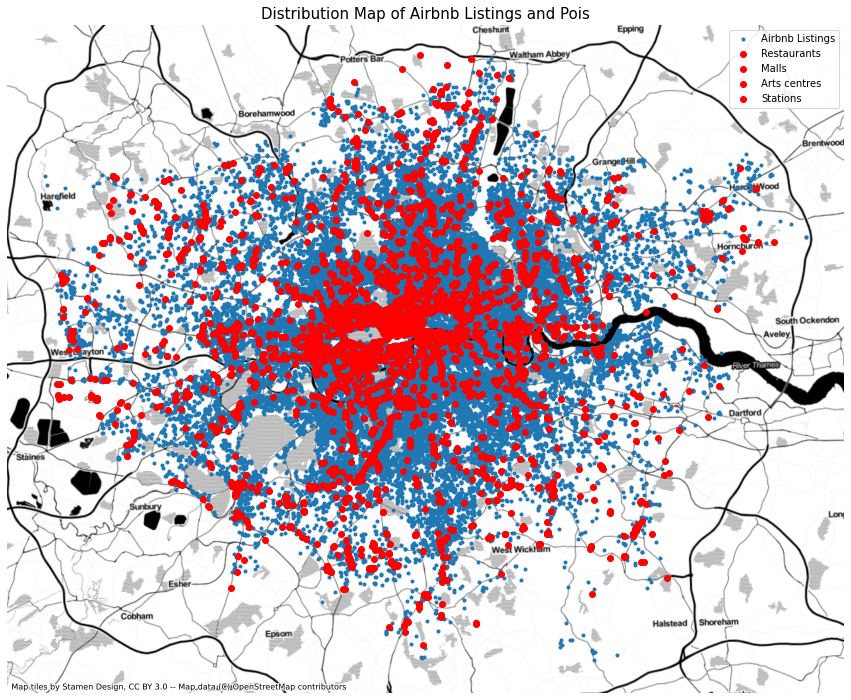

In [25]:
# Plot the airbnb and pois from openstreetmap
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(15, 15))
# Plot AirBnb properties
ml.plot(ax=ax, marker='.',label="Airbnb Listings")
# Plot POIs in red
restaurant.plot(ax=ax, color='r',label="Restaurants")
mall.plot(ax=ax, color='r',label="Malls")
arts_centre.plot(ax=ax, color='r',label="Arts centres")
station.plot(ax=ax, color='r',label="Stations")
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=ml.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.title('Distribution Map of Airbnb Listings and Pois', fontsize=15)
plt.legend(loc='best')
plt.show()

Then, we create some new columns which incorporates information about how many POIs are nearby each property. This kind of “feature counting” is useful in applications where the mere presence of nearby features can affect the quantity we are modeling.

*To do this kind of feature engineering, let us first walk through what we need to do at a conceptual level:

*Decide what is nearby. This will dictate how far we go from each AirBnB when counting the number of “nearby” bars & restaurants. For this example, we will use 500 meter buffer, which is approximately the distance of a leisurely ten-minute walk.

*For each AirBnB, determine whether POIs are within a leisurely ten-minute walk.

*Count how many POIs are within the specified radius of each AirBnB.

In [26]:
#feature engineering
#create the radius of 500m around each AirBnB
ml['buffer_500m'] = ml.buffer(500)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#count the number of POIs that are within these areas using a spatial join
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    restaurant,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    ml.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [28]:
joined

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity                name  \
element_type osmid                                        
node         451153      restaurant  Central Restaurant   
             264498970   restaurant      Ahir Lorenzo's   
             1546021376  restaurant              Divans   
             451153      restaurant  Central Restaurant   
             264498970   restaurant      Ahir Lorenzo's   
...                             ...                 ...   
way          1018324381  restaurant         The Manjill   
             1018324381  restaurant         The Manjill   
             1018324381  restaurant         The Manjill   
             1018324381  restaurant         The Manjill   
             1018324381  restaurant         The Manjill   

                                                                  geometry  \
element_type osmid                                                           
node         451153                          POINT (525209.351 190788.919)   
             264498970                       POINT (525209.327 190757.628)   
             1546021376                      POINT (525574.813 191183.463)   
             451153                          POINT (525209.351 190788.919)   
             264498970                       POINT (525209.327 190757.628)   
...                                                                    ...   
way          1018324381  POLYGON ((527521.734 184613.296, 527525.716 18...   
             1018324381  POLYGON ((527521.734 184613.296, 527525.716 18...   
             1018324381  POLYGON ((527521.734 184613.296, 527525.716 18...   
             1018324381  POLYGON ((527521.734 184613.296, 527525.716 18...   
             1018324381  POLYGON ((527521.734 184613.296, 527525.716 18...   

                        addr:city addr:housename addr:housenumber  \
element_type osmid                                                  
node         451153           NaN            NaN              NaN   
             264498970        NaN            NaN              NaN   
             1546021376       NaN            NaN              163   
             451153           NaN            NaN              NaN   
             264498970        NaN            NaN              NaN   
...                           ...            ...              ...   
way          1018324381    London            NaN               34   
             1018324381    London            NaN               34   
             1018324381    London            NaN               34   
             1018324381    London            NaN               34   
             1018324381    London            NaN               34   

                        addr:postcode     addr:street  cuisine fhrs:authority  \
element_type osmid                                                              
node         451153               NaN             NaN      NaN            NaN   
             264498970            NaN             NaN      NaN            NaN   
             1546021376        N3 1LJ   Ballards Lane  turkish            NaN   
             451153               NaN             NaN      NaN            NaN   
             264498970            NaN             NaN      NaN            NaN   
...                               ...             ...      ...            ...   
way          1018324381           NaN  England's Lane   indian            NaN   
             1018324381           NaN  England's Lane   indian            NaN   
             1018324381           NaN  England's Lane   indian            NaN   
             1018324381           NaN  England's Lane   indian            NaN   
             1018324381           NaN  England's Lane   indian            NaN   

                         ... note:name:zh website:en serving_system:buffet  \
element_type osmid       ...                                                 
node         451153      ...          NaN        NaN                   NaN   
             264498970   ...          NaN        NaN       

In [29]:
joined.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Group restaurant by Airbnb ID (`id`)
restaurant_count = joined.groupby(
    'id'
# Keep only restaurant id column (`osmid`)
)[
    'osmid'
# Count restaurantss by Airbnb + convert Series into DataFrame
].count().to_frame(
    'restaurant_count'
)
# Print top of the table
restaurant_count.reset_index(inplace=True)
restaurant_count

,id,restaurant_count
0,11551,49
1,13913,27
2,15400,33
3,17402,96
4,17506,28
...,...,...
59156,45084798,5
59157,45085490,8
59158,45085795,7
59159,45087861,2


In [31]:
# merge
ml_pois_counts= pd.merge(ml, restaurant_count, how='left')
ml_pois_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD,buffer_500m,restaurant_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633,"POLYGON ((531385.122 175377.940, 531382.715 17...",49.00
1,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633,"POLYGON ((531200.653 175090.560, 531198.245 17...",9.00
2,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633,"POLYGON ((531739.141 175099.960, 531736.734 17...",44.00
3,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633,"POLYGON ((531186.035 175010.067, 531183.628 17...",4.00
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633,"POLYGON ((531914.745 175083.347, 531912.337 17...",42.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67269,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466,"POLYGON ((550640.179 191914.988, 550637.771 19...",NaN
67270,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493,"POLYGON ((552774.419 182291.204, 552772.011 18...",3.00
67271,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493,"POLYGON ((552617.305 182274.253, 552614.897 18...",3.00
67272,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493,"POLYGON ((553072.598 182396.981, 553070.190 18...",2.00


In [32]:
# Calculate mall and airbnb listings
joined2 = gpd.sjoin(
    mall,
    ml.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    op="within"
)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [33]:
joined2.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Group mall by Airbnb ID (`id`)
mall_count = joined2.groupby(
    'id'
)[
    'osmid'
].count().to_frame(
    'mall_count'
)
mall_count.reset_index(inplace=True)
mall_count

,id,mall_count
0,15400,1
1,37384,3
2,47687,2
3,49970,1
4,56229,2
...,...,...
7049,45073411,1
7050,45073494,1
7051,45073710,1
7052,45077628,1


In [35]:
ml_pois_counts= pd.merge(ml_pois_counts, mall_count, how='left')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Calculate station and airbnb listings
joined3 = gpd.sjoin(
    station,
    ml.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    op="within"
)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [37]:
joined3.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Group station by Airbnb ID (`id`)
station_count = joined3.groupby(
    'id'
)[
    'osmid'
].count().to_frame(
    'station_count'
)
station_count.reset_index(inplace=True)
station_count

,id,station_count
0,11551,2
1,13913,1
2,17402,4
3,17506,1
4,36299,1
...,...,...
41113,45079487,1
41114,45083474,3
41115,45084798,1
41116,45085490,2


In [39]:
ml_pois_counts= pd.merge(ml_pois_counts, station_count, how='left')
ml_pois_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD,buffer_500m,restaurant_count,mall_count,station_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633,"POLYGON ((531385.122 175377.940, 531382.715 17...",49.00,NaN,2.00
1,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633,"POLYGON ((531200.653 175090.560, 531198.245 17...",9.00,NaN,1.00
2,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633,"POLYGON ((531739.141 175099.960, 531736.734 17...",44.00,NaN,2.00
3,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633,"POLYGON ((531186.035 175010.067, 531183.628 17...",4.00,NaN,NaN
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633,"POLYGON ((531914.745 175083.347, 531912.337 17...",42.00,NaN,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67269,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466,"POLYGON ((550640.179 191914.988, 550637.771 19...",NaN,NaN,NaN
67270,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493,"POLYGON ((552774.419 182291.204, 552772.011 18...",3.00,NaN,1.00
67271,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493,"POLYGON ((552617.305 182274.253, 552614.897 18...",3.00,NaN,1.00
67272,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493,"POLYGON ((553072.598 182396.981, 553070.190 18...",2.00,NaN,NaN


In [40]:
# Calculate arts_centre and airbnb listings
joined4 = gpd.sjoin(
    arts_centre,
    ml.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    op="within"
)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [41]:
joined4.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Group arts_centre by Airbnb ID (`id`)
arts_centre_count = joined4.groupby(
    'id'
)[
    'osmid'
].count().to_frame(
    'arts_centre_count'
)
arts_centre_count.reset_index(inplace=True)
arts_centre_count

,id,arts_centre_count
0,15400,1
1,17402,3
2,38995,1
3,42692,1
4,47192,1
...,...,...
13388,45065787,1
13389,45073431,2
13390,45073494,1
13391,45073710,1


In [43]:
ml_pois_counts= pd.merge(ml_pois_counts, arts_centre_count, how='left')
ml_pois_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD,buffer_500m,restaurant_count,mall_count,station_count,arts_centre_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633,"POLYGON ((531385.122 175377.940, 531382.715 17...",49.00,NaN,2.00,NaN
1,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633,"POLYGON ((531200.653 175090.560, 531198.245 17...",9.00,NaN,1.00,NaN
2,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633,"POLYGON ((531739.141 175099.960, 531736.734 17...",44.00,NaN,2.00,NaN
3,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633,"POLYGON ((531186.035 175010.067, 531183.628 17...",4.00,NaN,NaN,NaN
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633,"POLYGON ((531914.745 175083.347, 531912.337 17...",42.00,NaN,2.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67269,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466,"POLYGON ((550640.179 191914.988, 550637.771 19...",NaN,NaN,NaN,NaN
67270,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493,"POLYGON ((552774.419 182291.204, 552772.011 18...",3.00,NaN,1.00,NaN
67271,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493,"POLYGON ((552617.305 182274.253, 552614.897 18...",3.00,NaN,1.00,NaN
67272,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493,"POLYGON ((553072.598 182396.981, 553070.190 18...",2.00,NaN,NaN,NaN


In [44]:
ml_pois_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD,buffer_500m,restaurant_count,mall_count,station_count,arts_centre_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633,"POLYGON ((531385.122 175377.940, 531382.715 17...",49.00,NaN,2.00,NaN
1,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633,"POLYGON ((531200.653 175090.560, 531198.245 17...",9.00,NaN,1.00,NaN
2,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633,"POLYGON ((531739.141 175099.960, 531736.734 17...",44.00,NaN,2.00,NaN
3,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633,"POLYGON ((531186.035 175010.067, 531183.628 17...",4.00,NaN,NaN,NaN
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633,"POLYGON ((531914.745 175083.347, 531912.337 17...",42.00,NaN,2.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67269,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466,"POLYGON ((550640.179 191914.988, 550637.771 19...",NaN,NaN,NaN,NaN
67270,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493,"POLYGON ((552774.419 182291.204, 552772.011 18...",3.00,NaN,1.00,NaN
67271,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493,"POLYGON ((552617.305 182274.253, 552614.897 18...",3.00,NaN,1.00,NaN
67272,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493,"POLYGON ((553072.598 182396.981, 553070.190 18...",2.00,NaN,NaN,NaN


In [45]:
# make NAN=0
ml_final=ml_pois_counts.fillna(0)
ml_final

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,geometry,MSOA11CD,buffer_500m,restaurant_count,mall_count,station_count,arts_centre_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,POINT (530885.122 175377.940),E02000633,"POLYGON ((531385.122 175377.940, 531382.715 17...",49.00,0.00,2.00,0.00
1,65908,1,1.00,2,4,0,0.00,4.38,0,POINT (530700.653 175090.560),E02000633,"POLYGON ((531200.653 175090.560, 531198.245 17...",9.00,0.00,1.00,0.00
2,408888,1,1.00,1,1125,0,0.00,5.30,0,POINT (531239.141 175099.960),E02000633,"POLYGON ((531739.141 175099.960, 531736.734 17...",44.00,0.00,2.00,0.00
3,502576,5,1.00,2,10,5,1.00,5.14,0,POINT (530686.035 175010.067),E02000633,"POLYGON ((531186.035 175010.067, 531183.628 17...",4.00,0.00,0.00,0.00
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,POINT (531414.745 175083.347),E02000633,"POLYGON ((531914.745 175083.347, 531912.337 17...",42.00,0.00,2.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67269,39857777,1,1.00,1,7,3,0.00,3.83,0,POINT (550140.179 191914.988),E02000466,"POLYGON ((550640.179 191914.988, 550637.771 19...",0.00,0.00,0.00,0.00
67270,40560364,3,1.00,7,30,0,0.00,3.91,0,POINT (552274.419 182291.204),E02000493,"POLYGON ((552774.419 182291.204, 552772.011 18...",3.00,0.00,1.00,0.00
67271,41315638,3,1.00,7,30,0,0.00,3.40,0,POINT (552117.305 182274.253),E02000493,"POLYGON ((552617.305 182274.253, 552614.897 18...",3.00,0.00,1.00,0.00
67272,41686355,3,3.00,2,1125,1,1.00,5.12,0,POINT (552572.598 182396.981),E02000493,"POLYGON ((553072.598 182396.981, 553070.190 18...",2.00,0.00,0.00,0.00


In [46]:
ml_final.describe()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,restaurant_count,mall_count,station_count,arts_centre_count
count,"67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00","67,274.00"
mean,"23,985,027.72",24.74,1.41,4.93,"23,647.22",17.89,15.57,4.38,24.29,0.12,0.98,0.25
std,"12,558,210.15",121.27,0.92,21.32,"4,354,514.23",38.04,77.81,0.80,49.91,0.39,1.07,0.55
min,"11,551.00",1.00,0.00,1.00,1.00,0.00,0.00,1.95,0.00,0.00,0.00,0.00
25%,"13,992,982.00",1.00,1.00,1.00,38.00,0.00,0.00,3.81,3.00,0.00,0.00,0.00
50%,"23,818,573.50",2.00,1.00,2.00,"1,125.00",4.00,1.00,4.37,10.00,0.00,1.00,0.00
75%,"34,809,155.50",5.00,2.00,3.00,"1,125.00",18.00,2.00,4.87,27.00,0.00,1.00,0.00
max,"45,088,660.00","1,309.00",22.00,"1,125.00","999,999,999.00",790.00,717.00,9.83,485.00,4.00,7.00,4.00


## 2.Data Visualization

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([], [])

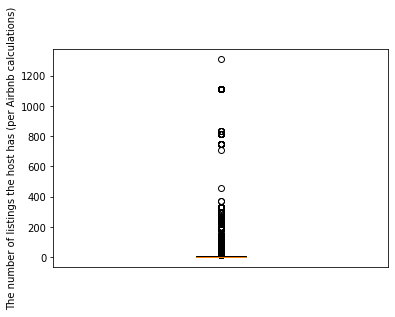

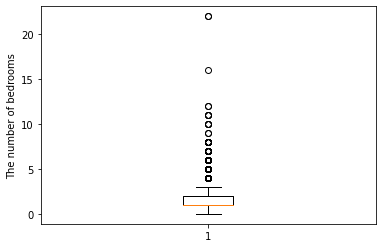

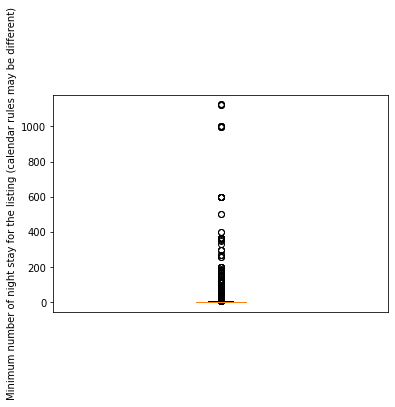

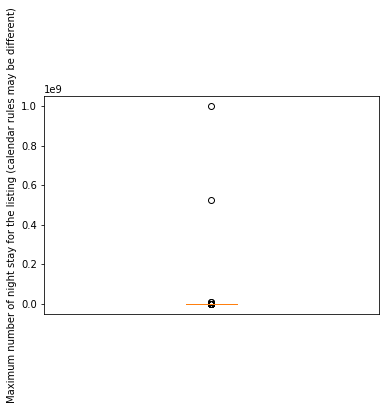

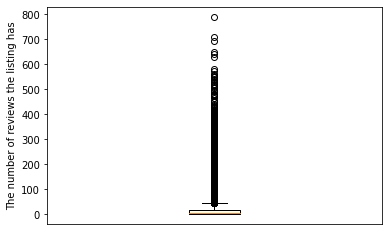

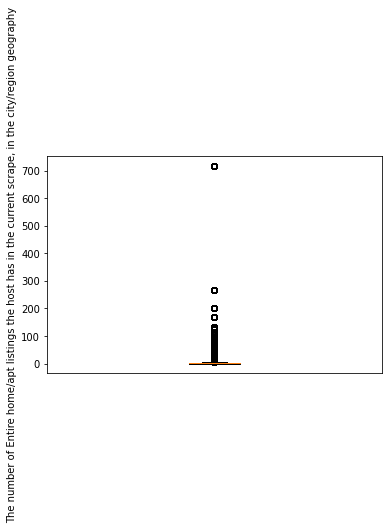

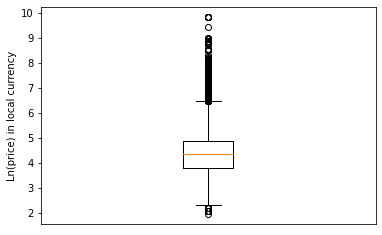

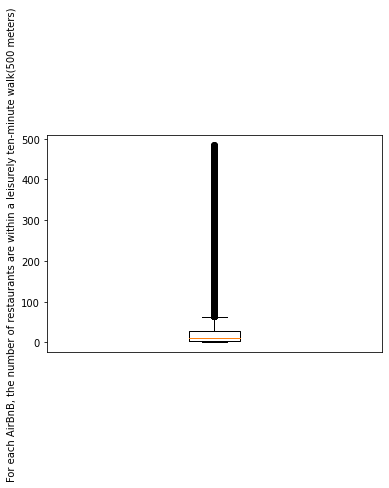

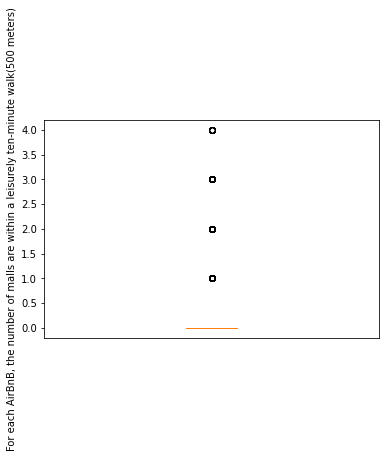

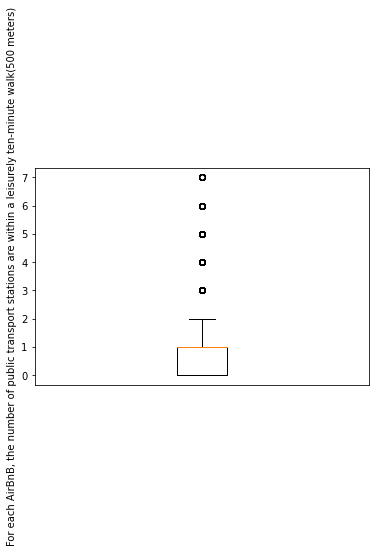

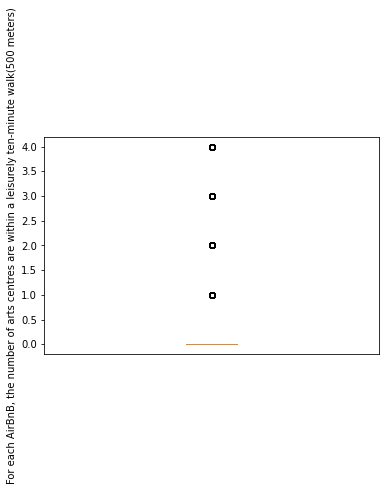

In [47]:
#boxplot for each data
plt.figure(1)
plt.boxplot(ml_final['host_total_listings_count']) #-> seems to be a few with high obesidy %
plt.ylabel("The number of listings the host has (per Airbnb calculations)")
plt.xticks([])

plt.figure(2)
plt.boxplot(ml_final['bedrooms'])
plt.ylabel("The number of bedrooms")

plt.figure(3)
plt.boxplot(ml_final['minimum_nights'])
plt.ylabel("Minimum number of night stay for the listing (calendar rules may be different)")
plt.xticks([])

#remove outliers for tax (2 points above 100% - must be some mistake in data)
#df_final_rm = df_final[df_final['tax_2019']<100]

#plot cleaned tax data
plt.figure(4)
plt.boxplot(ml_final['maximum_nights'])
plt.ylabel("Maximum number of night stay for the listing (calendar rules may be different)")
plt.xticks([])
#plt.savefig('xx_rm.jpg')

plt.figure(5)
plt.boxplot(ml_final['number_of_reviews'])
plt.ylabel("The number of reviews the listing has")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(6)
plt.boxplot(ml_final['calculated_host_listings_count_entire_homes'])
plt.ylabel("The number of Entire home/apt listings the host has in the current scrape, in the city/region geography")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(7)
plt.boxplot(ml_final['l_price'])
plt.ylabel("Ln(price) in local currency")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(8)
plt.boxplot(ml_final['restaurant_count'])
plt.ylabel("For each AirBnB, the number of restaurants are within a leisurely ten-minute walk(500 meters)")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(9)
plt.boxplot(ml_final['mall_count'])
plt.ylabel("For each AirBnB, the number of malls are within a leisurely ten-minute walk(500 meters)")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(10)
plt.boxplot(ml_final['station_count'])
plt.ylabel("For each AirBnB, the number of public transport stations are within a leisurely ten-minute walk(500 meters)")
plt.xticks([])
#plt.savefig('xx.jpg')

plt.figure(11)
plt.boxplot(ml_final['arts_centre_count'])
plt.ylabel("For each AirBnB, the number of arts centres are within a leisurely ten-minute walk(500 meters)")
plt.xticks([])
#plt.savefig('xx.jpg')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


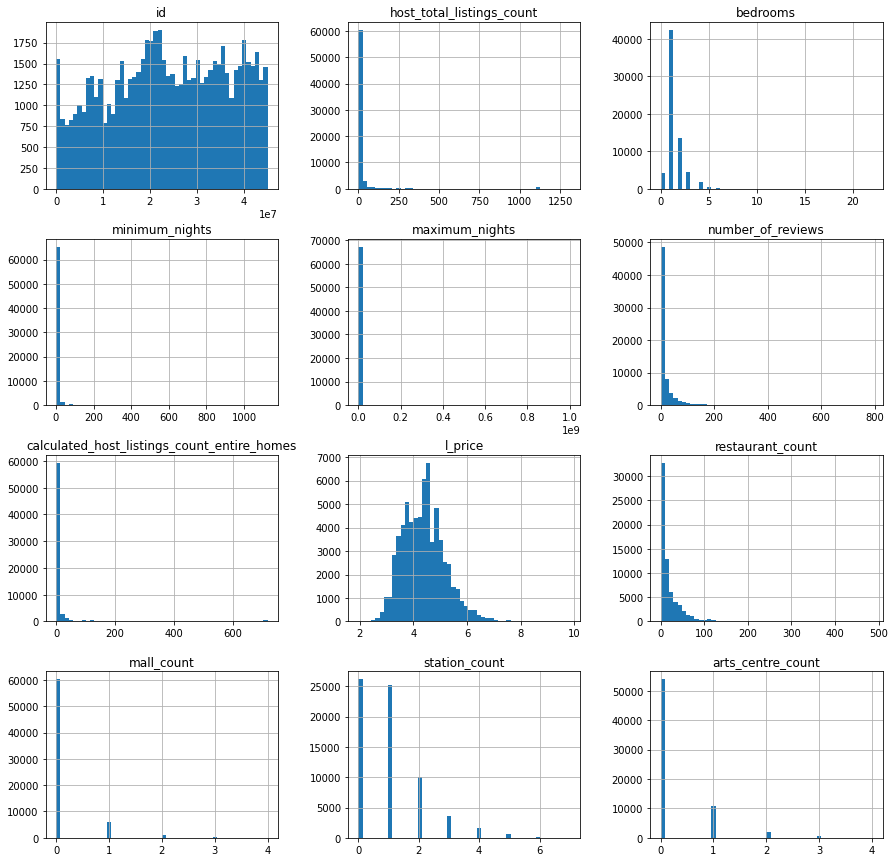

In [48]:
# histograms
ml_final.hist(figsize=(15,15),bins=50)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<function matplotlib.pyplot.show(close=None, block=None)>

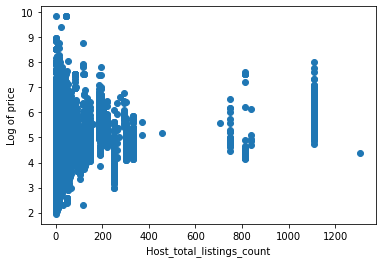

In [49]:
# plot host_total_lisitngs_count and log of price
plt.scatter(ml_final['host_total_listings_count'],ml_final['l_price'])
plt.xlabel('Host_total_listings_count')
plt.ylabel('Log of price')
plt.show

It seems that there is a negative relationship between prices and the number of listings on property. 

## . Model 1: A (standard) hedonic price model

In [50]:
ml_final2 = ml_final.drop(columns=['buffer_500m','geometry','MSOA11CD'])

In [51]:
ml_final2.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,host_total_listings_count,bedrooms,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count_entire_homes,l_price,mhost,restaurant_count,mall_count,station_count,arts_centre_count
0,11551,3,1.00,2,180,192,2.00,4.47,0,49.00,0.00,2.00,0.00
1,65908,1,1.00,2,4,0,0.00,4.38,0,9.00,0.00,1.00,0.00
2,408888,1,1.00,1,1125,0,0.00,5.30,0,44.00,0.00,2.00,0.00
3,502576,5,1.00,2,10,5,1.00,5.14,0,4.00,0.00,0.00,0.00
4,1194557,1,2.00,4,1125,52,1.00,4.70,0,42.00,0.00,2.00,0.00


In [52]:
ml_final2['mhost'] = pd.to_numeric(ml_final['mhost'])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
ml_final2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           67274 non-null  int64  
 1   host_total_listings_count                    67274 non-null  int64  
 2   bedrooms                                     67274 non-null  float64
 3   minimum_nights                               67274 non-null  int64  
 4   maximum_nights                               67274 non-null  int64  
 5   number_of_reviews                            67274 non-null  int64  
 6   calculated_host_listings_count_entire_homes  67274 non-null  float64
 7   l_price                                      67274 non-null  float64
 8   mhost                                        67274 non-null  int64  
 9   restaurant_count                             67274 non-null  flo

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Correlation Matrix')

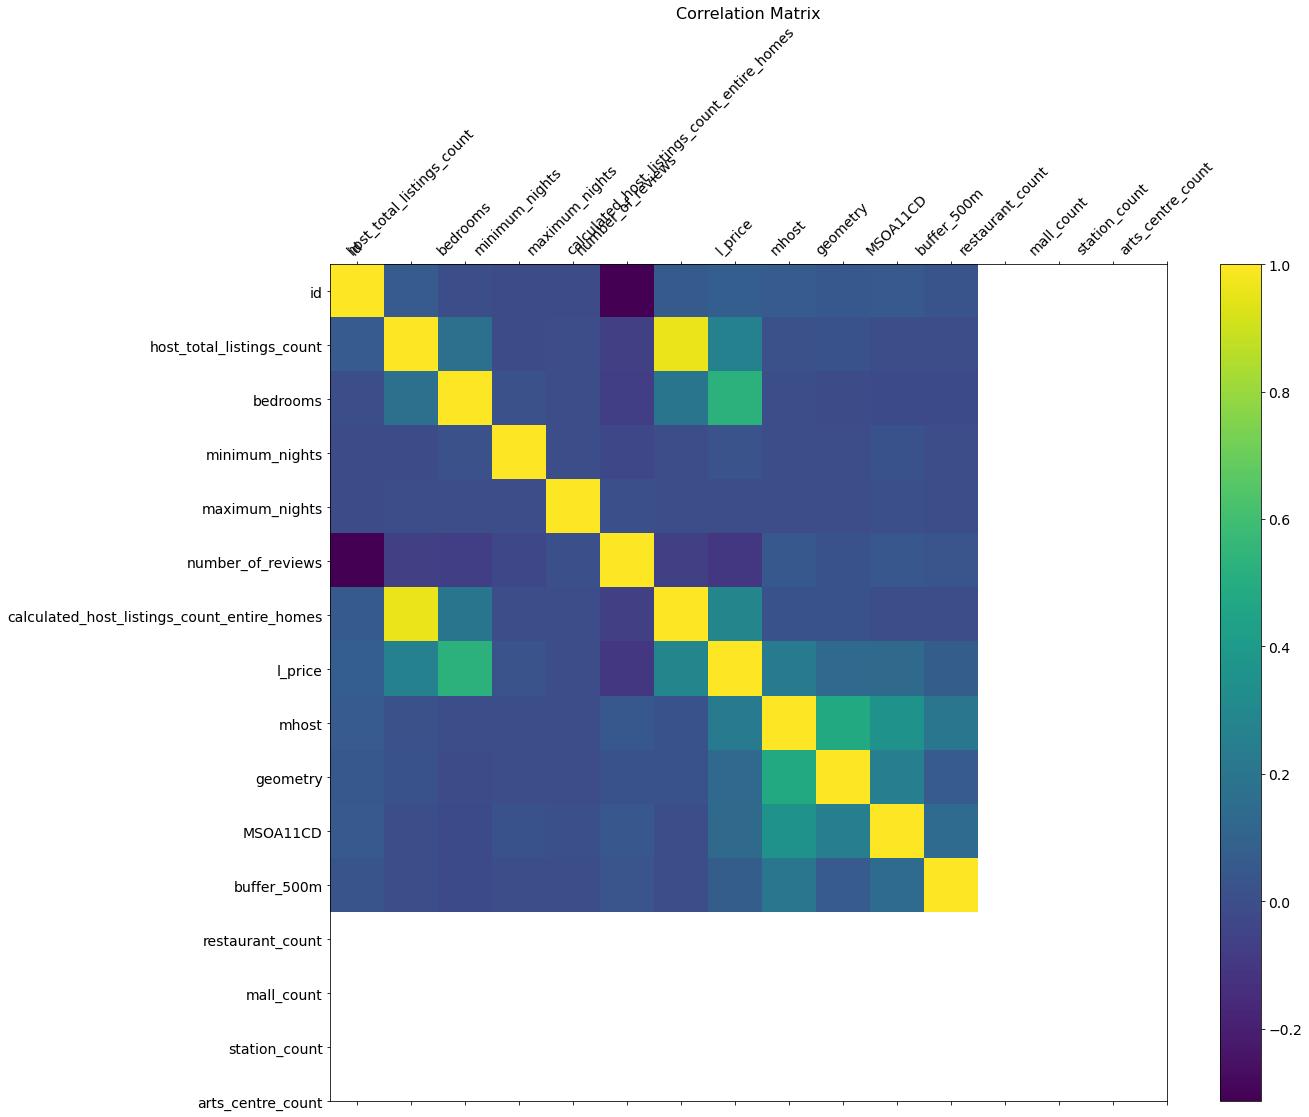

In [54]:
df = ml_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(ml_final.corr(), fignum=f.number)
plt.xticks(range(ml_final.shape[1]), ml_final.columns, fontsize=14, rotation=45)
plt.yticks(range(ml_final.shape[1]), ml_final.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [55]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(ml_final2, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(ml_final2)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            ml_final2 = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return ml_final2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tools/numdiff.py:51: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  EPS = np.MachAr().eps


In [56]:
ml_final_VIF = drop_column_using_vif_(ml_final2.drop(['l_price','calculated_host_listings_count_entire_homes'], axis=1))
ml_final_VIF.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Index(['id', 'host_total_listings_count', 'bedrooms', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'mhost', 'restaurant_count',
       'mall_count', 'station_count', 'arts_centre_count'],
      dtype='object')

In [57]:
import statsmodels.api as sm

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
ml_final2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           67274 non-null  int64  
 1   host_total_listings_count                    67274 non-null  int64  
 2   bedrooms                                     67274 non-null  float64
 3   minimum_nights                               67274 non-null  int64  
 4   maximum_nights                               67274 non-null  int64  
 5   number_of_reviews                            67274 non-null  int64  
 6   calculated_host_listings_count_entire_homes  67274 non-null  float64
 7   l_price                                      67274 non-null  float64
 8   mhost                                        67274 non-null  int64  
 9   restaurant_count                             67274 non-null  flo

In [59]:
#A (standard) hedonic price model
#d Impact of each intervention area - multiple regression
#regression analysis

hedonic_result = sm.OLS(endog=ml_final2[['l_price']], exog=sm.add_constant(ml_final_VIF)).fit()
hedonic_result.summary()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     3975.
Date:                Tue, 11 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:26:03   Log-Likelihood:                -63314.
No. Observations:               67274   AIC:                         1.267e+05
Df Residuals:                   67262   BIC:                         1.268e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.6080      0.007    494.936      0.000       3.594       3.622
id                        -5.042e-11   2.06e-10     -0.245      0.807   -4.54e-10    3.53e-10
host_total_listings_count     0.0007   2.18e-05     33.062      0.000       0.001       0.001
bedrooms                      0.4234      0.003    160.624      0.000       0.418       0.429
minimum_nights                0.0005      0.000      4.183      0.000       0.000       0.001
maximum_nights            -5.397e-10   5.49e-10     -0.983      0.326   -1.62e-09    5.37e-10
number_of_reviews            -0.0014   6.67e-05    -20.730      0.000      -0.002      -0.001
mhost                         0.3279      0.007     45.915      0.000       0.314       0.342
restaurant_count              0.0025   5.85e-05     42.839      0.000       0.002       0.003
mall_count                    0.0582      0.007      8.297      0.000       0.044       0.072
station_count                 0.0471      0.002     19.440      0.000       0.042       0.052
arts_centre_count             0.0423      0.004      9.425      0.000       0.033       0.051
==============================================================================
Omnibus:                     7194.966   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30422.837
Skew:                           0.467   Prob(JB):                         0.00
Kurtosis:                       6.159   Cond. No.                     8.66e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


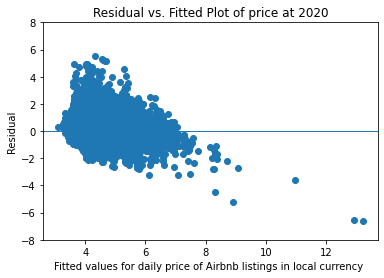

In [60]:
# plot 
plt.scatter(hedonic_result.fittedvalues, hedonic_result.resid)
# adding title and labels
plt.xlabel('Fitted values for daily price of Airbnb listings in local currency ')
plt.ylabel('Residual')
plt.ylim(-8,8)
plt.title('Residual vs. Fitted Plot of price at 2020')
plt.axhline(linewidth=1)
plt.show()

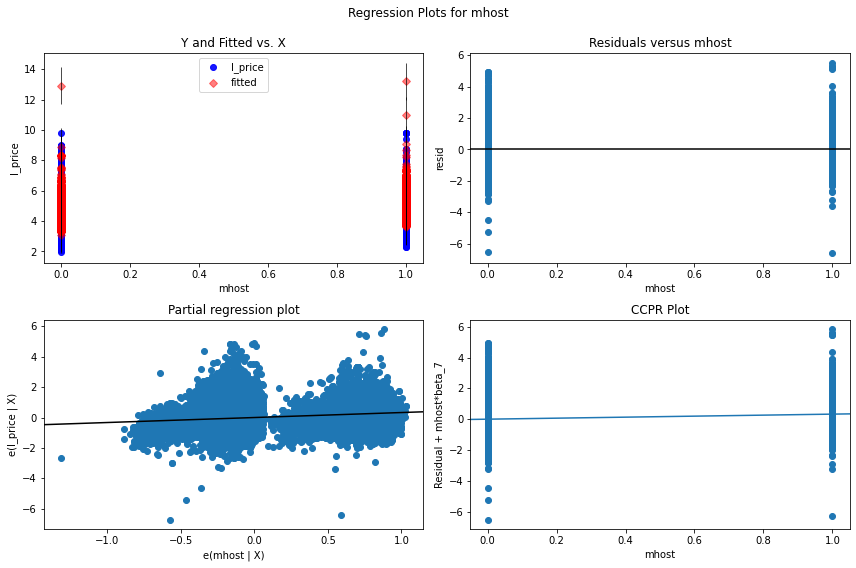

In [61]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(hedonic_result, 'mhost', fig=fig)

## 4.Evaluate Spatial autocorrelation

In [62]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/numba/np/arraymath.py:3845: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)
/opt/anaconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shap

Plot the distribution of residuals in each msoas

In [63]:
# Create column with residual values 
ml_final['residual']= hedonic_result.resid
# Obtain the median value of residuals in each msoa
medians = ml_final.groupby(
    "MSOA11CD"
).residual.median().to_frame(
    'mosa_residual'
)
medians.reset_index(inplace=True)
medians

,MSOA11CD,mosa_residual
0,E02000001,0.55
1,E02000002,-0.12
2,E02000003,-0.34
3,E02000005,-0.62
4,E02000007,-0.31
...,...,...
972,E02006927,-0.21
973,E02006928,-0.12
974,E02006929,0.01
975,E02006930,0.01


<AxesSubplot:>

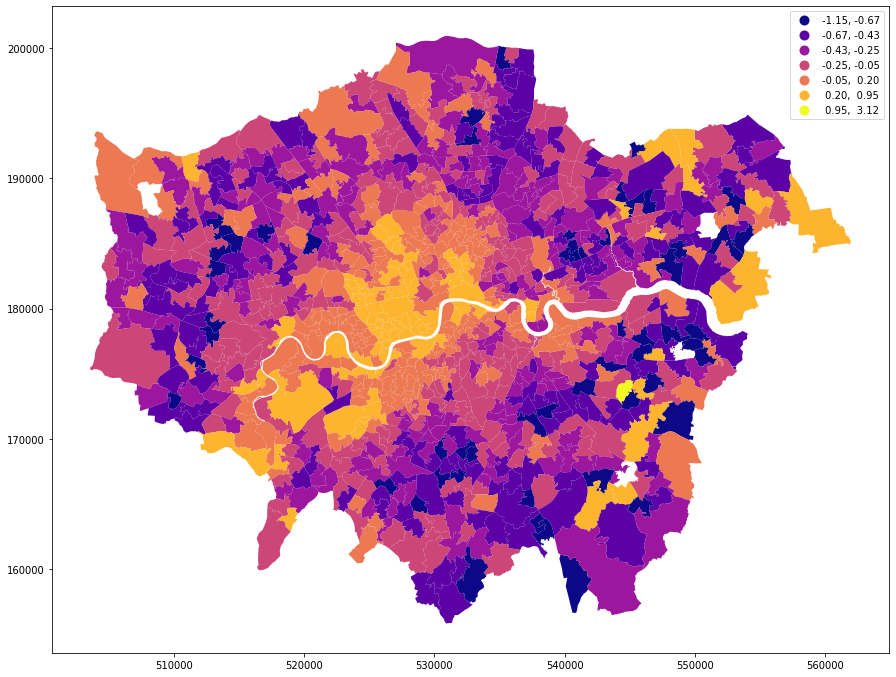

In [64]:
medians2 = msoas.set_index('MSOA11CD').join(medians.set_index('MSOA11CD'))
medians2.plot(column='mosa_residual', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(15,15))

Looking at the map above, there look to be some purple areas next to other purple areas and some yellow/orange areas next to other yellow/orange areas. This suggests that there could well be some spatial autocorrelation biasing our model.

In [65]:
ml_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   id                                           67274 non-null  int64   
 1   host_total_listings_count                    67274 non-null  int64   
 2   bedrooms                                     67274 non-null  float64 
 3   minimum_nights                               67274 non-null  int64   
 4   maximum_nights                               67274 non-null  int64   
 5   number_of_reviews                            67274 non-null  int64   
 6   calculated_host_listings_count_entire_homes  67274 non-null  float64 
 7   l_price                                      67274 non-null  float64 
 8   mhost                                        67274 non-null  object  
 9   geometry                                     67274 no

In [66]:
ml_k= ml_final

In [67]:
ml_k.drop(columns=["id",'calculated_host_listings_count_entire_homes','MSOA11CD','buffer_500m'], inplace=True)

In [68]:
ml_k['mhost'] = pd.to_numeric(ml_k['mhost'])

In [69]:
ml_k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   host_total_listings_count  67274 non-null  int64   
 1   bedrooms                   67274 non-null  float64 
 2   minimum_nights             67274 non-null  int64   
 3   maximum_nights             67274 non-null  int64   
 4   number_of_reviews          67274 non-null  int64   
 5   l_price                    67274 non-null  float64 
 6   mhost                      67274 non-null  int64   
 7   geometry                   67274 non-null  geometry
 8   restaurant_count           67274 non-null  float64 
 9   mall_count                 67274 non-null  float64 
 10  station_count              67274 non-null  float64 
 11  arts_centre_count          67274 non-null  float64 
 12  residual                   67274 non-null  float64 
dtypes: float64(7), geometry

In [70]:
# knn
knn = weights.KNN.from_dataframe(ml_k, k=30)

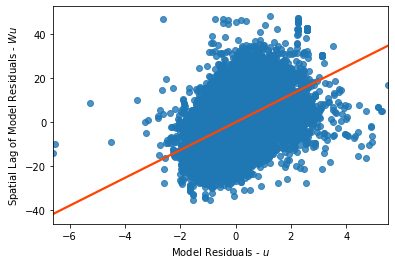

In [71]:
lag_residual = weights.spatial_lag.lag_spatial(knn, hedonic_result.resid)
lag_residual = np.array(lag_residual)
hedonic_result.resid = np.array(hedonic_result.resid)
ax = sns.regplot(
    hedonic_result.resid.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

In this plot, we see that our prediction errors tend to cluster! 
Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it.

In [72]:
from pysal.explore import esda

Given this behavior, let’s look at the stable 𝑘=100 number of neighbors. Examining the relationship between this stable surrounding average and the focal AirBnB, we can even find clusters in our model error. Recalling the local Moran statistics , 
we can identify certain areas where our predictions of the nightly (log) AirBnB price tend to be significantly off:

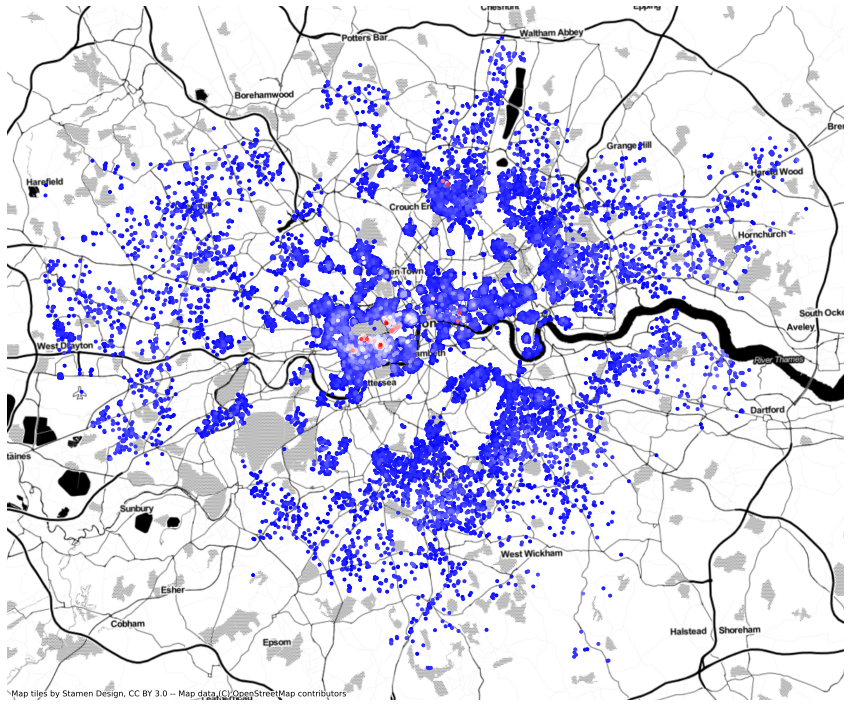

In [73]:
# Re-weight W to 100 nearest neighbors
knn.reweight(k=100, inplace=True)
# Row standardise weights
knn.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(hedonic_result.resid, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = ml_k.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.',figsize=(15,15)
)
# Add basemap
contextily.add_basemap(ax, crs=ml_k.crs,source=contextily.providers.Stamen.Toner)
# Remove axes
ax.set_axis_off();

Thus, these areas tend to be locations where our model significantly under-predicts the nightly AirBnB price both for that specific observation and observations in its immediate surroundings. This is critical since, if we can identify how these areas are structured — if they have a consistent geography that we can model — then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas. 

In [74]:
# 
correlations = []
nulls = []
for order in range(28 , 100, 1):
    knn.reweight(k=order, inplace=True) #operates in place, quickly and efficiently avoiding copies
    knn.transform = 'r'
    lag_residual = weights.spatial_lag.lag_spatial(knn, hedonic_result.resid)
    random_residual = hedonic_result.resid[numpy.random.permutation(len(hedonic_result.resid))] 
    random_lag_residual = weights.spatial_lag.lag_spatial(
        knn, random_residual
    ) # identical to random neighbors in KNN 
    correlations.append(
        numpy.corrcoef(hedonic_result.resid.flatten(), lag_residual.flatten())[0,1]
    )
    nulls.append(
        numpy.corrcoef(hedonic_result.resid.flatten(), random_lag_residual.flatten())[0,1]
    )

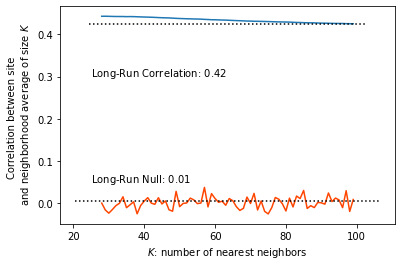

In [75]:
plt.plot(range(28,100,1), correlations)
plt.plot(range(28,100,1), nulls, color='orangered')
plt.hlines(numpy.mean(correlations[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.hlines(numpy.mean(nulls[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.text(s='Long-Run Correlation: ${:.2f}$'.format(numpy.mean(correlations[-3:])), x=25,y=.3)
plt.text(s='Long-Run Null: ${:.2f}$'.format(numpy.mean(nulls[-3:])), x=25, y=.05)
plt.xlabel('$K$: number of nearest neighbors')
plt.ylabel("Correlation between site \n and neighborhood average of size $K$")
plt.show()

## 5.Model2: SLX Model

In [76]:
ml_s=ml_k

In [77]:
ml_s.drop(columns=['geometry','residual'], inplace=True)

In [78]:
variable_names = [
    'host_total_listings_count',   
    'bedrooms',      
    'minimum_nights',        
    'maximum_nights',          
    'number_of_reviews',
    'mhost',  
    'restaurant_count', 
    'mall_count',       
    'station_count',      
    'arts_centre_count'     
]

In [79]:
# Compute the spatial lag of each of those variables
wx = ml_s.apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
# Rename the spatial lag, adding w_ to the original name
).rename(
    columns=lambda c: 'w_'+c
)
wx.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   w_host_total_listings_count  67274 non-null  float64
 1   w_bedrooms                   67274 non-null  float64
 2   w_minimum_nights             67274 non-null  float64
 3   w_maximum_nights             67274 non-null  float64
 4   w_number_of_reviews          67274 non-null  float64
 5   w_l_price                    67274 non-null  float64
 6   w_mhost                      67274 non-null  float64
 7   w_restaurant_count           67274 non-null  float64
 8   w_mall_count                 67274 non-null  float64
 9   w_station_count              67274 non-null  float64
 10  w_arts_centre_count          67274 non-null  float64
dtypes: float64(11)
memory usage: 6.2 MB


In [80]:
wx.drop(columns=['w_l_price'], inplace=True)

In [81]:
from pysal.model import spreg

In [82]:
# Merge original variables with the spatial lags in `wx`
slx_exog = ml_s[variable_names].join(wx)
# Fit linear model with `spreg`
m2 = spreg.OLS(
    # Dependent variable
    ml_s[['l_price']].values, 
    # Independent variables
    slx_exog.values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y='l_price', 
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)

In [83]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     l_price                Number of Observations:       67274
Mean dependent var  :      4.3815                Number of Variables   :          21
S.D. dependent var  :      0.7966                Degrees of Freedom    :       67253
R-squared           :      0.4363
Adjusted R-squared  :      0.4362
Sum squared residual:   24063.544                F-statistic           :   2603.0988
Sigma-square        :       0.358                Prob(F-statistic)     :           0
S.E. of regression  :       0.598                Log likelihood        :  -60876.284
Sigma-square ML     :       0.358                Akaike info criterion :  121794.568
S.E of regression ML:      0.5981                Schwarz criterion     :  121986.015

-----------------------------------------------------------------------------

In [84]:
# Collect names of variables of interest
vars_of_interest = ml_s[
    variable_names
].join(
    wx
).columns
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m2.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m2.t_stat]
    },
    index=m2.name_x
# Subset for variables of itnerest only and round to
# four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
host_total_listings_count,0.00,0.00,0.00
bedrooms,0.42,0.00,0.00
minimum_nights,0.00,0.00,0.09
maximum_nights,-0.00,0.00,0.30
number_of_reviews,-0.00,0.00,0.00
mhost,0.19,0.01,0.00
restaurant_count,-0.00,0.00,0.00
mall_count,0.03,0.01,0.02
station_count,0.01,0.00,0.30
arts_centre_count,-0.04,0.01,0.00


## 6.Model3: Two-regime spatial hedonic model

In [85]:
wx.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67274 entries, 0 to 67273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   w_host_total_listings_count  67274 non-null  float64
 1   w_bedrooms                   67274 non-null  float64
 2   w_minimum_nights             67274 non-null  float64
 3   w_maximum_nights             67274 non-null  float64
 4   w_number_of_reviews          67274 non-null  float64
 5   w_mhost                      67274 non-null  float64
 6   w_restaurant_count           67274 non-null  float64
 7   w_mall_count                 67274 non-null  float64
 8   w_station_count              67274 non-null  float64
 9   w_arts_centre_count          67274 non-null  float64
dtypes: float64(10)
memory usage: 7.7 MB


In [86]:
# PySAL spatial regimes implementation
slx_exog = ml_s[variable_names].join(wx)
m3 = spreg.OLS_Regimes(
    # Dependent variable
    ml_s[['l_price']].values, 
    # Independent variables
    slx_exog.values,
    # Variable specifying neighborhood membership
    ml_s['mhost'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=True,
    # Dependent variable name
    name_y='l_price', 
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)

In [87]:
print(m3.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   0_l_price                Number of Observations:       55198
Mean dependent var  :      4.2692                Number of Variables   :          20
S.D. dependent var  :      0.7339                Degrees of Freedom    :       55178
R-squared           :      0.3701
Adjusted R-squared  :      0.3699
Sum squared residual:   18724.222                F-statistic           :   1706.6400
Sigma-square        :       0.339                Prob(F-statistic)     :           0
S.E. of regression  :       0.583                Log likelihood        :  -48485.049
Sigma-square ML     :       0.339                Akaike info criterion :   97010.097
S.E of regression ML:      0.5824                Schwarz criterion     :   97188.471

--------------------------------